# EDA on text data
## Import necessary libraries

In [15]:
import sys
IN_COLAB = 'google.colab' in sys.modules
IN_COLAB

False

In [ ]:
# # Use TPU
# if IN_COLAB:
#     # TPU Setting
#     import os
#     assert os.environ['COLAB_TPU_ADDR'], 'Make sure to select TPU from Edit > Notebook setting > Hardware accelerator'
    
#     VERSION = "20200220"
#     !curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
#     !python pytorch-xla-env-setup.py --version $VERSION

In [ ]:
# Note: After the following pip install, need to restart the kernel.
# Required modules - written here so that it can setup a new instance in Colab. Not required to run every time.
if IN_COLAB:
    !pip install numpy==1.16.4
    !pip install pandas==0.25.0
    !pip install torch==1.4.0
    !pip install tqdm==4.43.0
    !pip install scikit-plot

In [91]:
# Python libraries
import datetime as dt
import re
import pickle
from tqdm.notebook import tqdm
import os
import sys
import time
import logging
import random
from collections import defaultdict, Counter

# Data Science modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
plt.style.use('ggplot')

# Import Scikit-learn moduels
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score, plot_confusion_matrix
from sklearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import model_selection
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_validate, StratifiedKFold, learning_curve, RandomizedSearchCV

# Import nltk modules and download dataset
import nltk
from nltk.corpus import stopwords
from nltk.util import ngrams
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

stop = set(stopwords.words('english'))

# Import Pytorch modules
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import (DataLoader, RandomSampler, SequentialSampler, TensorDataset)
from torch.autograd import Variable

[nltk_data] Downloading package stopwords to /Users/yuki/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/yuki/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/yuki/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [92]:
# Set logger
logger = logging.getLogger('mylogger')
logger.setLevel(logging.DEBUG)
timestamp = time.strftime("%Y.%m.%d_%H.%M.%S", time.localtime())
fh = logging.FileHandler('log_model.txt')
fh.setLevel(logging.DEBUG)
ch = logging.StreamHandler()
ch.setLevel(logging.DEBUG)
formatter = logging.Formatter('[%(asctime)s][%(levelname)s] ## %(message)s')
fh.setFormatter(formatter)
ch.setFormatter(formatter)
logger.addHandler(fh)
logger.addHandler(ch)

In [93]:
# Set Random Seed
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
rand_seed = 42

In [94]:
# Set Seaborn Style
sns.set(style='white', context='notebook', palette='deep')

In [95]:
# Check Device
if IN_COLAB:
    torch.cuda.get_device_name(0)

## Load preprocessed data

In [ ]:
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')

In [16]:
# Load previously processed non-text data
# Load data
if IN_COLAB:
    file = open('drive/My Drive/Colab Data/nontext_train_small.pickle', 'rb')
else:
    file = open('../data/train_data/nontext_train_small.pickle', 'rb')
train_df = pickle.load(file)
file.close()

print(train_df.shape)
train_df


(398, 10)


,target,prev_decision,GDP_diff_prev,PMI_value,Employ_diff_prev,Rsales_diff_year,Unemp_diff_prev,Inertia_diff,Hsales_diff_year,Balanced_diff
date,,,,,,,,,,
1982-10-05,-1,0,0.456197,38.8,-169.0,1.807631,-0.166667,-0.018226,-15.485275,0.003723
1982-11-16,-1,-1,-0.382295,39.4,-228.0,1.807631,-0.200000,-0.018226,-9.537496,0.003723
1982-12-21,0,-1,-0.382295,39.2,-198.5,1.807631,-0.333333,-0.018226,-3.116275,0.003723
1983-01-14,0,0,-0.382295,42.8,-68.0,1.807631,-0.233333,-0.018226,-0.774432,0.003723
1983-01-21,0,0,-0.382295,42.8,-68.0,1.807631,-0.233333,-0.043785,-0.774432,0.003723
1983-01-28,0,0,-0.382295,42.8,-68.0,1.807631,-0.233333,-0.043785,-0.774432,0.003723
1983-02-09,0,0,0.039942,46.0,102.0,1.807631,0.000000,-0.091455,6.403612,0.003723
1983-03-29,1,0,0.039942,54.4,73.0,1.807631,0.133333,-0.104496,13.270610,0.003723
1983-04-29,0,1,0.039942,53.9,50.0,1.807631,0.166667,0.076200,20.486913,0.003723


In [17]:
# Load text data
file = open('../data/preprocessed/text_no_split.pickle', 'rb') # Original text
text_no_split = pickle.load(file)
file.close()

file = open('../data/preprocessed/text_split_200.pickle', 'rb') # Split at 200 words
text_split_200 = pickle.load(file)
file.close()


file = open('../data/preprocessed/text_keyword.pickle', 'rb') # Paragraphs filtered for those having keywords
text_keyword = pickle.load(file)
file.close()

## Check the statistics of texts

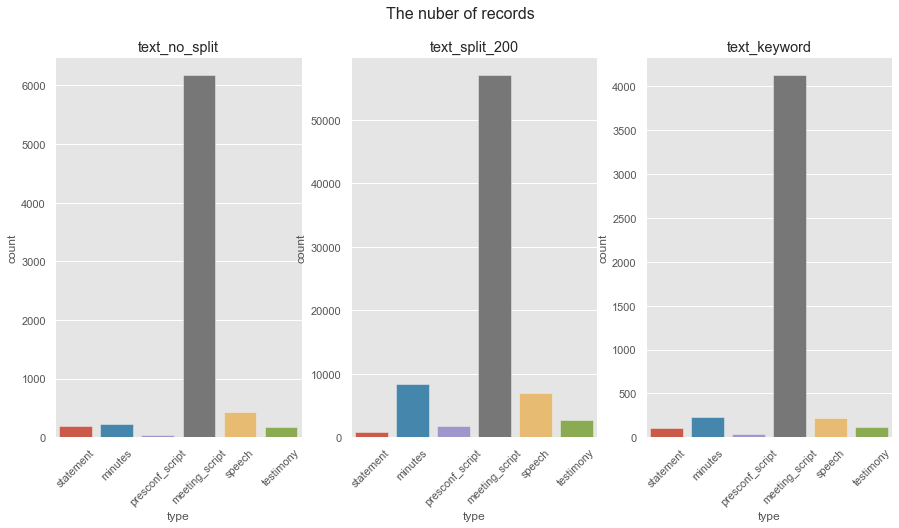

In [18]:
# Check the number of records per document type
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,7))
sns.countplot(x='type', data=text_no_split, ax=ax1)
ax1.set_title('text_no_split')
ax1.tick_params('x', labelrotation=45)
sns.countplot(x='type', data=text_split_200, ax=ax2)
ax2.set_title('text_split_200')
ax2.tick_params('x', labelrotation=45)
sns.countplot(x='type', data=text_keyword, ax=ax3)
ax3.set_title('text_keyword')
ax3.tick_params('x', labelrotation=45)
fig.suptitle("The nuber of records", fontsize=16)
plt.show()


In [19]:
text_no_split.loc[text_no_split['type'] == 'meeting_script'].head()

,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text
467,meeting_script,1990-02-07,FOMC Meeting Transcript,CHAIRMAN GREENSPAN,903,0,8.25,1990-03-27,0,8.25,There's another thing that I suspect all...
468,meeting_script,1990-02-07,FOMC Meeting Transcript,CHAIRMAN GREENSPAN,1220,0,8.25,1990-03-27,0,8.25,And to the extent that the process migh...
469,meeting_script,1990-02-07,FOMC Meeting Transcript,MR. ANGELL,163,0,8.25,1990-03-27,0,8.25,"You can move to amend, that's right. Mr..."
470,meeting_script,1990-02-07,FOMC Meeting Transcript,MR. ANGELL. My number for real GNP,681,0,8.25,1990-03-27,0,8.25,is right underneath thestaff's at 1-1/2 p...
471,meeting_script,1990-02-07,FOMC Meeting Transcript,MR. BERNARD,256,0,8.25,1990-03-27,0,8.25,I'm reading from line 59 of the draft d...


There are many meeting scripts but we do not use them this time as they cannot be used for prediction of the rate decision because meeting scripts are published four years after the meeting.

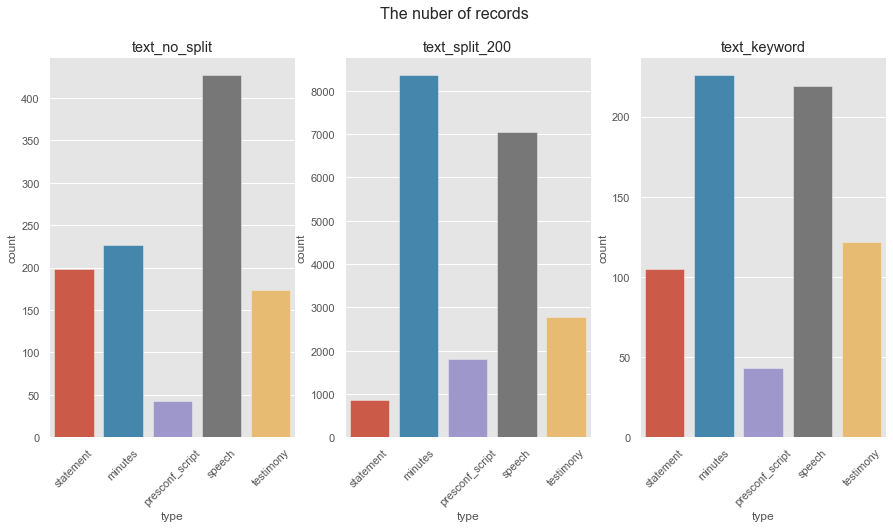

In [20]:
# Drop meeting script data
text_no_split = text_no_split.loc[text_no_split['type'] != 'meeting_script']
text_split_200 = text_split_200.loc[text_split_200['type'] != 'meeting_script']
text_keyword = text_keyword.loc[text_keyword['type'] != 'meeting_script']

# Check the number of records per document type
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,7))
sns.countplot(x='type', data=text_no_split, ax=ax1)
ax1.set_title('text_no_split')
ax1.tick_params('x', labelrotation=45)
sns.countplot(x='type', data=text_split_200, ax=ax2)
ax2.set_title('text_split_200')
ax2.tick_params('x', labelrotation=45)
sns.countplot(x='type', data=text_keyword, ax=ax3)
ax3.set_title('text_keyword')
ax3.tick_params('x', labelrotation=45)
fig.suptitle("The nuber of records", fontsize=16)
plt.show()

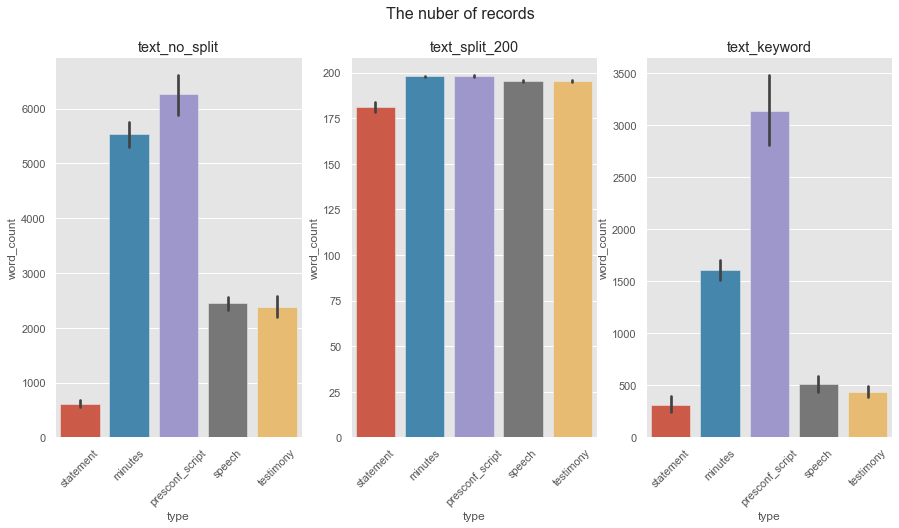

In [21]:
# Check the number of words per document type
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,7))
sns.barplot(data=text_no_split, x='type', y='word_count', ax=ax1)
ax1.set_title('text_no_split')
ax1.tick_params('x', labelrotation=45)
sns.barplot(x='type', y='word_count', data=text_split_200, ax=ax2)
ax2.set_title('text_split_200')
ax2.tick_params('x', labelrotation=45)
sns.barplot(x='type', y='word_count', data=text_keyword, ax=ax3)
ax3.set_title('text_keyword')
ax3.tick_params('x', labelrotation=45)
fig.suptitle("The nuber of records", fontsize=16)
plt.show()

### Select text dataframe

In [22]:
# Select one from the above different pre-processed data
text_df = text_no_split
text_df.reset_index(drop=True, inplace=True)
print(text_df.shape)
text_df

(1068, 11)


,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text
0,statement,1994-02-04,FOMC Statement,Alan Greenspan,99,1,3.25,1994-02-28,0,3.25,Chairman Alan Greenspan announced today that t...
1,statement,1994-03-22,FOMC Statement,Alan Greenspan,40,1,3.5,1994-04-18,1,3.75,Chairman Alan Greenspan announced today that t...
2,statement,1994-04-18,FOMC Statement,Alan Greenspan,37,1,3.75,1994-05-17,1,4.25,Chairman Alan Greenspan announced today that t...
3,statement,1994-05-17,FOMC Statement,Alan Greenspan,57,1,4.25,1994-07-06,0,4.25,"In taking the discount action, the Board appro..."
4,statement,1994-08-16,FOMC Statement,Alan Greenspan,51,1,4.75,1994-09-27,0,4.75,"In taking the discount rate action, the Board ..."
5,statement,1994-11-15,FOMC Statement,Alan Greenspan,121,1,5.5,1994-12-20,0,5.50,"In a related move, the Federal Open Market Com..."
6,statement,1995-02-01,FOMC Statement,Alan Greenspan,54,1,6,1995-03-10,0,6.00,"In taking the discount action, the Board appro..."
7,statement,1995-07-06,FOMC Statement,Alan Greenspan,67,-1,5.75,1995-08-22,0,5.75,Chairman Alan Greenspan announced today that t...
8,statement,1995-12-19,FOMC Statement,Alan Greenspan,81,-1,5.5,1996-01-31,-1,5.25,Chairman Alan Greenspan announced today that t...
9,statement,1996-01-31,FOMC Statement,Alan Greenspan,391,-1,5.25,1996-03-26,0,5.25,For immediate releaseThe Federal Reserve today...


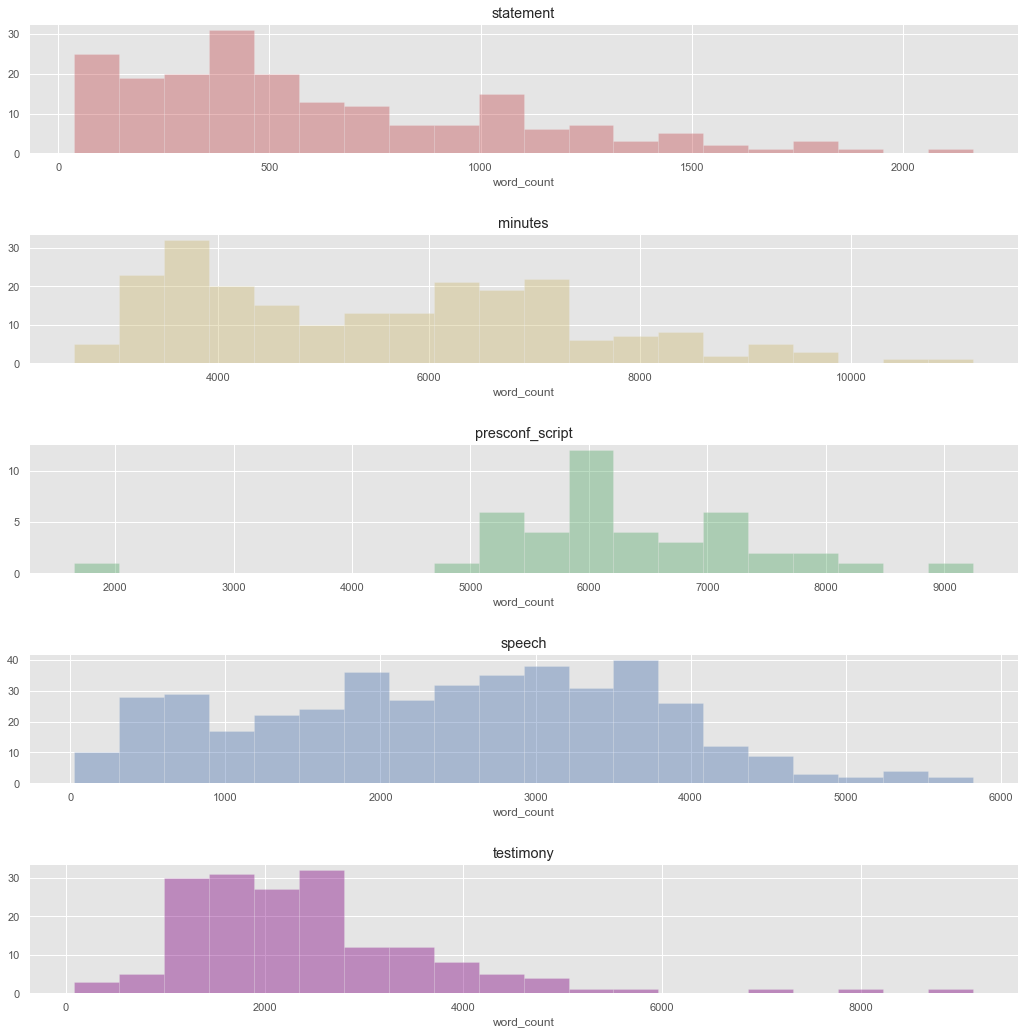

In [23]:
# Check distribution

fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1, figsize=(15,15))
doc_type = 'statement'
sns.distplot(text_df.loc[text_df['type'] == doc_type]['word_count'], bins=20, ax=ax1, kde=False, color='r')
ax1.set_title(doc_type)
doc_type = 'minutes'
sns.distplot(text_df.loc[text_df['type'] == doc_type]['word_count'], bins=20, ax=ax2, kde=False, color='y')
ax2.set_title(doc_type)
doc_type = 'presconf_script'
sns.distplot(text_df.loc[text_df['type'] == doc_type]['word_count'], bins=20, ax=ax3, kde=False, color='g')
ax3.set_title(doc_type)
doc_type = 'speech'
sns.distplot(text_df.loc[text_df['type'] == doc_type]['word_count'], bins=20, ax=ax4, kde=False, color='b')
ax4.set_title(doc_type)
doc_type = 'testimony'
sns.distplot(text_df.loc[text_df['type'] == doc_type]['word_count'], bins=20, ax=ax5, kde=False, color='purple')
ax5.set_title(doc_type)

fig.tight_layout(pad=3.0)
plt.show()

/Users/yuki/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


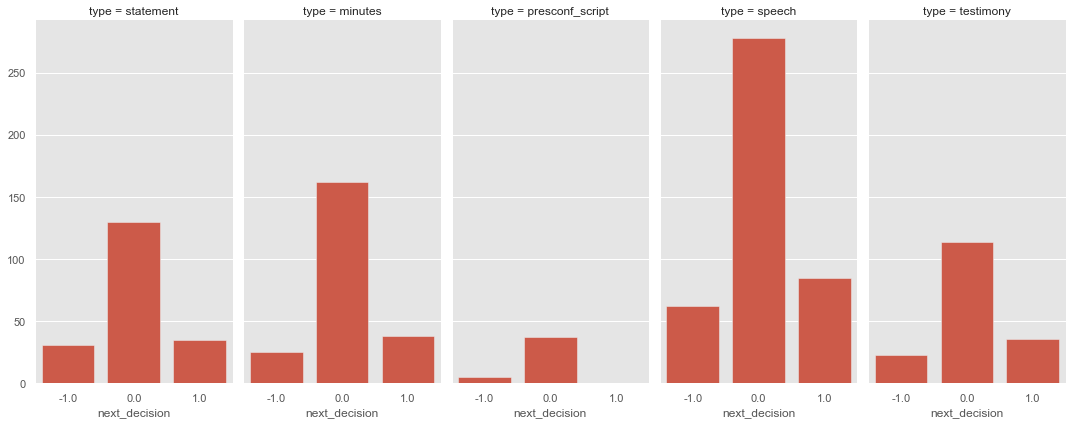

In [24]:
# Check balance of Rate Decision

g = sns.FacetGrid(text_df, col='type', height=6, aspect=0.5)
g.map(sns.countplot, 'next_decision')
plt.show()


The label is highly biased to 0(Hold). Need to consider how to mitigate the biased data.

## Merge text to the train dataframe

In [25]:
from collections import defaultdict 

doc_types = text_df['type'].unique()

merged_dict = defaultdict(list)

for i, row in train_df.iterrows():
    text_rows = text_df.loc[text_df['next_meeting'] == i]
    merged_text_all = ""
    for doc_type in doc_types:
        merged_text = ""
        for text in text_rows.loc[text_rows['type'] == doc_type]['text']:
            merged_text += " " + text
        merged_dict[doc_type].append(merged_text)
        merged_text_all += merged_text
    merged_dict['text'].append(merged_text_all)
    

In [26]:
for key in merged_dict.keys():
    train_df[key] = merged_dict[key]

train_df

,target,prev_decision,GDP_diff_prev,PMI_value,Employ_diff_prev,Rsales_diff_year,Unemp_diff_prev,Inertia_diff,Hsales_diff_year,Balanced_diff,statement,minutes,presconf_script,speech,testimony,text
date,,,,,,,,,,,,,,,,
1982-10-05,-1,0,0.456197,38.8,-169.0,1.807631,-0.166667,-0.018226,-15.485275,0.003723,,,,,,
1982-11-16,-1,-1,-0.382295,39.4,-228.0,1.807631,-0.200000,-0.018226,-9.537496,0.003723,,,,,,
1982-12-21,0,-1,-0.382295,39.2,-198.5,1.807631,-0.333333,-0.018226,-3.116275,0.003723,,,,,,
1983-01-14,0,0,-0.382295,42.8,-68.0,1.807631,-0.233333,-0.018226,-0.774432,0.003723,,,,,,
1983-01-21,0,0,-0.382295,42.8,-68.0,1.807631,-0.233333,-0.043785,-0.774432,0.003723,,,,,,
1983-01-28,0,0,-0.382295,42.8,-68.0,1.807631,-0.233333,-0.043785,-0.774432,0.003723,,,,,,
1983-02-09,0,0,0.039942,46.0,102.0,1.807631,0.000000,-0.091455,6.403612,0.003723,,,,,,
1983-03-29,1,0,0.039942,54.4,73.0,1.807631,0.133333,-0.104496,13.270610,0.003723,,,,,,
1983-04-29,0,1,0.039942,53.9,50.0,1.807631,0.166667,0.076200,20.486913,0.003723,,,,,,


In [27]:
# Check if most of docs are merged

count_text, count_train = 0, 0

for doc_type in doc_types:
    count = 0
    for text in text_df.loc[text_df['type']==doc_type]['text']:
        count += len(text.split())
    print("{} words in original text for {}".format(count, doc_type))
    count_text += count
    
    count = 0
    for text in train_df[doc_type]:
        count += len(text.split())
    print("{} words in merged text for {}".format(count, doc_type))
    count_train += count

print("Total: {} words in original text".format(count_text))
print("Total: {} words in merged text".format(count_train))
print("Total: {} words in text column of merged text".format(train_df['text'].apply(lambda x: len(x.split())).sum()))

122473 words in original text for statement
121762 words in merged text for statement
1245796 words in original text for minutes
1238045 words in merged text for minutes
260217 words in original text for presconf_script
253982 words in merged text for presconf_script
1038969 words in original text for speech
1037401 words in merged text for speech
412334 words in original text for testimony
410549 words in merged text for testimony
Total: 3079789 words in original text
Total: 3061739 words in merged text
Total: 3061739 words in text column of merged text


Looks okay, but there are may rows without text as texts are only available from certain year.
It's not easy to fill those null values - for now drop those though the number of training data gets small...

In [28]:
print("Before dropping: ", train_df.shape)
train_df = train_df.loc[train_df['text'] != ""]
print("After dropping: ", train_df.shape)

Before dropping:  (398, 16)
After dropping:  (245, 16)


## Explore the text

In [29]:
# Corpus
def create_corpus(df):
    corpus = []
    
    for x in df['text'].str.split():
        for i in x:
            corpus.append(i.lower())
    return corpus

# Returns Top X frequent stop words
def get_frequent_stop_words(corpus, top_n=10):
    dic = defaultdict(int)
    for word in corpus:
        if word in stop:
            dic[word] += 1

    top = sorted(dic.items(), key=lambda x: x[1], reverse=True)[:top_n]

    return zip(*top)

# Returns Top X frequent non stop words
def get_frequent_nonstop_words(corpus, top_n=10):
    dic = defaultdict(int)
    for word in corpus:
        if word not in stop:
            dic[word] += 1

    top = sorted(dic.items(), key=lambda x: x[1], reverse=True)[:top_n]

    return zip(*top)

In [30]:
corpus = create_corpus(text_df)

In [31]:
x, y = get_frequent_stop_words(corpus)

In [32]:
print(x)
print(y)

('the', 'of', 'in', 'to', 'and', 'a', 'that', 'for', 'on', 'as')
(211758, 115310, 96530, 91970, 89615, 48229, 46555, 32689, 23338, 22436)


In [33]:
x, y = get_frequent_nonstop_words(corpus)

In [34]:
print(x)
print(y)

('economic', 'financial', 'federal', 'inflation', 'market', 'would', 'rate', 'policy', 'growth', 'committee')
(14159, 13464, 13177, 12533, 11179, 10980, 10440, 9930, 9209, 8018)


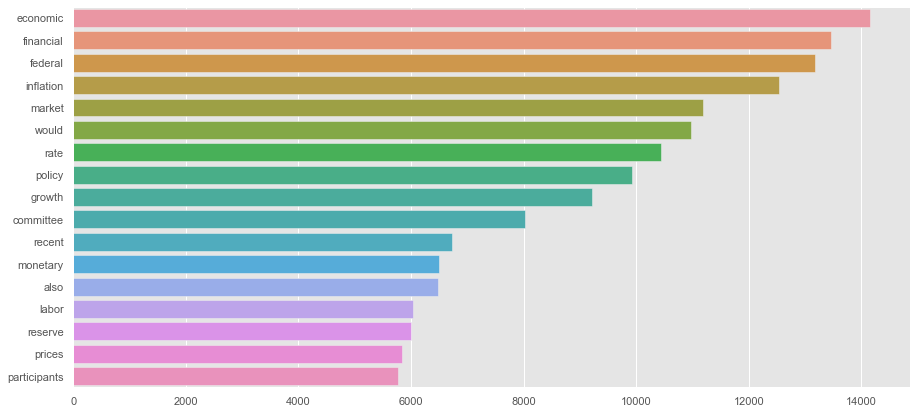

In [35]:
# Check most frequent words which are not in stopwords
counter = Counter(corpus)
most = counter.most_common()[:60]
x, y = [], []
for word, count in most:
    if word not in stop:
        x.append(word)
        y.append(count)

plt.figure(figsize=(15,7))
sns.barplot(x=y, y=x)

# Add sentiment based on Loughran and McDonald Sentiment Word Lists

Use Loughran and McDonald Sentiment Word Lists (https://sraf.nd.edu/textual-analysis/resources/) for sentiment analysis. Use the master word list, combined in two columns (sentiment and word).
<BR /> Note: This data requires license to use for commercial application. Please check their website.

In [36]:
# Load sentiment data
sentiment_df = pd.read_csv('../data/LoughranMcDonald/LoughranMcDonald_SentimentWordLists_2018.csv')

print(sentiment_df.shape)
sentiment_df

(4140, 2)


,sentiment,word
0,Negative,ABANDON
1,Negative,ABANDONED
2,Negative,ABANDONING
3,Negative,ABANDONMENT
4,Negative,ABANDONMENTS
5,Negative,ABANDONS
6,Negative,ABDICATED
7,Negative,ABDICATES
8,Negative,ABDICATING
9,Negative,ABDICATION


In [37]:
# Make all words lower case
sentiment_df['word'] = sentiment_df['word'].str.lower()
sentiments = sentiment_df['sentiment'].unique()
sentiment_df.groupby(by=['sentiment']).count()

,word
sentiment,
Constraining,184
Litigious,904
Negative,2355
Positive,354
StrongModal,19
Uncertainty,297
WeakModal,27


In [38]:
sentiment_dict = { sentiment: sentiment_df.loc[sentiment_df['sentiment']==sentiment]['word'].values.tolist() for sentiment in sentiments}

## Analyze the tone with negation without lemmatization

In [39]:
# Consider Negation
negate = ["aint", "arent", "cannot", "cant", "couldnt", "darent", "didnt", "doesnt", "ain't", "aren't", "can't",
          "couldn't", "daren't", "didn't", "doesn't", "dont", "hadnt", "hasnt", "havent", "isnt", "mightnt", "mustnt",
          "neither", "don't", "hadn't", "hasn't", "haven't", "isn't", "mightn't", "mustn't", "neednt", "needn't",
          "never", "none", "nope", "nor", "not", "nothing", "nowhere", "oughtnt", "shant", "shouldnt", "wasnt",
          "werent", "oughtn't", "shan't", "shouldn't", "wasn't", "weren't", "without", "wont", "wouldnt", "won't",
          "wouldn't", "rarely", "seldom", "despite", "no", "nobody"]

def negated(word):
    """
    Determine if preceding word is a negation word
    """
    if word.lower() in negate:
        return True
    else:
        return False

def tone_count_with_negation_check(dict, article):
    """
    Count positive and negative words with negation check. Account for simple negation only for positive words.
    Simple negation is taken to be observations of one of negate words occurring within three words
    preceding a positive words.
    """
    pos_count = 0
    neg_count = 0
    tone_score = 0

    pos_words = []
    neg_words = []
 
    input_words = re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', article.lower())
    word_count = len(input_words)
     
    for i in range(0, word_count):
        if input_words[i] in dict['Negative']:
            neg_count += 1
            neg_words.append(input_words[i])
        if input_words[i] in dict['Positive']:
            if i >= 3:
                if negated(input_words[i - 1]) or negated(input_words[i - 2]) or negated(input_words[i - 3]):
                    neg_count += 1
                    neg_words.append(input_words[i] + ' (with negation)')
                else:
                    pos_count += 1
                    pos_words.append(input_words[i])
            elif i == 2:
                if negated(input_words[i - 1]) or negated(input_words[i - 2]):
                    neg_count += 1
                    neg_words.append(input_words[i] + ' (with negation)')
                else:
                    pos_count += 1
                    pos_words.append(input_words[i])
            elif i == 1:
                if negated(input_words[i - 1]):
                    neg_count += 1
                    neg_words.append(input_words[i] + ' (with negation)')
                else:
                    pos_count += 1
                    pos_words.append(input_words[i])
            elif i == 0:
                pos_count += 1
                pos_words.append(input_words[i])
 
    if word_count > 0:
        tone_score = 100 * (pos_count - neg_count) / word_count
    else:
        tone_score = 0
    
    results = [tone_score, word_count, pos_count, neg_count, pos_words, neg_words]
 
    return results

columns = ['tone_score', 'word_count', 'n_pos_words', 'n_neg_words', 'pos_words', 'neg_words']

In [40]:
# Analyze tone for original text dataframe
print(text_df.shape)
tone_lmdict = [tone_count_with_negation_check(sentiment_dict, x) for x in tqdm(text_df['text'], total=text_df.shape[0])]
tone_lmdict_df = pd.DataFrame(tone_lmdict, columns=columns)
text_df = pd.concat([text_df, tone_lmdict_df.reindex(text_df.index)], axis=1)
text_df


(1068, 11)


,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,tone_score,word_count,n_pos_words,n_neg_words,pos_words,neg_words
0,statement,1994-02-04,FOMC Statement,Alan Greenspan,99,1,3.25,1994-02-28,0,3.25,Chairman Alan Greenspan announced today that t...,0.000000,99,1,1,[enhance],[misunderstanding]
1,statement,1994-03-22,FOMC Statement,Alan Greenspan,40,1,3.5,1994-04-18,1,3.75,Chairman Alan Greenspan announced today that t...,0.000000,40,0,0,[],[]
2,statement,1994-04-18,FOMC Statement,Alan Greenspan,37,1,3.75,1994-05-17,1,4.25,Chairman Alan Greenspan announced today that t...,0.000000,37,0,0,[],[]
3,statement,1994-05-17,FOMC Statement,Alan Greenspan,57,1,4.25,1994-07-06,0,4.25,"In taking the discount action, the Board appro...",0.000000,57,0,0,[],[]
4,statement,1994-08-16,FOMC Statement,Alan Greenspan,51,1,4.75,1994-09-27,0,4.75,"In taking the discount rate action, the Board ...",0.000000,51,0,0,[],[]
5,statement,1994-11-15,FOMC Statement,Alan Greenspan,121,1,5.5,1994-12-20,0,5.50,"In a related move, the Federal Open Market Com...",-0.826446,121,1,2,[strength],"[against, persistent]"
6,statement,1995-02-01,FOMC Statement,Alan Greenspan,54,1,6,1995-03-10,0,6.00,"In taking the discount action, the Board appro...",0.000000,54,0,0,[],[]
7,statement,1995-07-06,FOMC Statement,Alan Greenspan,67,-1,5.75,1995-08-22,0,5.75,Chairman Alan Greenspan announced today that t...,-2.985075,67,0,2,[],"[tightening, decline]"
8,statement,1995-12-19,FOMC Statement,Alan Greenspan,81,-1,5.5,1996-01-31,-1,5.25,Chairman Alan Greenspan announced today that t...,-2.469136,81,1,3,[favorable],"[easing, easing, decline]"
9,statement,1996-01-31,FOMC Statement,Alan Greenspan,391,-1,5.25,1996-03-26,0,5.25,For immediate releaseThe Federal Reserve today...,0.000000,391,3,3,"[effective, effective, effective]","[easing, easing, easing]"


In [41]:
# Analyze tone for training dataframe
tone_lmdict_list = []
for doc_type in doc_types:
    tone_lmdict = [tone_count_with_negation_check(sentiment_dict, x)[0] for x in tqdm(train_df[doc_type], 
                                                                                      total=train_df.shape[0], 
                                                                                      desc=doc_type)]
    tone_lmdict_list.append(tone_lmdict)
    
train_df['tone'] = np.mean(tone_lmdict_list, axis=0)
train_df

/Users/yuki/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


,target,prev_decision,GDP_diff_prev,PMI_value,Employ_diff_prev,Rsales_diff_year,Unemp_diff_prev,Inertia_diff,Hsales_diff_year,Balanced_diff,statement,minutes,presconf_script,speech,testimony,text,tone
date,,,,,,,,,,,,,,,,,
1993-02-18,0,0,1.043165,55.8,261.0,1.807631,0.000000,-0.015902,14.901418,0.035879,,The Secretary reported that advices of the el...,,,,The Secretary reported that advices of the el...,-0.146711
1993-05-18,0,0,0.167400,50.2,126.0,3.092456,0.066667,-0.000720,13.455236,0.111134,,"At the start of the meeting, the subcommittee...",,,,"At the start of the meeting, the subcommittee...",-0.163716
1993-07-07,0,0,0.167400,49.6,226.5,4.263357,0.000000,0.050013,13.446869,-0.016140,,The Committee then turned to a discussion of ...,,,,The Committee then turned to a discussion of ...,-0.267331
1993-08-17,0,0,0.582420,50.2,243.5,4.611673,0.066667,0.001967,11.927296,0.028625,,The Committee then turned to a discussion of ...,,,,The Committee then turned to a discussion of ...,-0.110953
1993-09-21,0,0,0.582420,50.7,228.5,4.894733,0.100000,-0.006682,10.302509,-0.010715,,Secretary's Note: Advice had been received of...,,,,Secretary's Note: Advice had been received of...,-0.170616
1993-10-05,0,0,0.582420,50.8,196.5,4.567647,0.100000,0.001512,8.487682,-0.001201,,"By unanimous vote, Joan E. Lovett and Peter R...",,,,"By unanimous vote, Joan E. Lovett and Peter R...",-0.168253
1993-12-21,0,0,0.477315,53.8,268.0,4.732363,0.066667,0.018879,9.597330,-0.037480,,The Committee then turned to a discussion of ...,,,,The Committee then turned to a discussion of ...,-0.078038
1994-02-04,1,0,1.360113,56.0,305.5,3.968305,0.066667,0.027275,11.608081,-0.077404,,The Committee then turned to a discussion of ...,,,,The Committee then turned to a discussion of ...,-0.034575
1994-02-28,0,1,1.360113,56.0,305.5,3.968305,0.066667,0.047744,11.608081,-0.028708,Chairman Alan Greenspan announced today that ...,"By unanimous vote, the following officers of ...",,,,Chairman Alan Greenspan announced today that ...,-0.009599


In [42]:
train_df

,target,prev_decision,GDP_diff_prev,PMI_value,Employ_diff_prev,Rsales_diff_year,Unemp_diff_prev,Inertia_diff,Hsales_diff_year,Balanced_diff,statement,minutes,presconf_script,speech,testimony,text,tone
date,,,,,,,,,,,,,,,,,
1993-02-18,0,0,1.043165,55.8,261.0,1.807631,0.000000,-0.015902,14.901418,0.035879,,The Secretary reported that advices of the el...,,,,The Secretary reported that advices of the el...,-0.146711
1993-05-18,0,0,0.167400,50.2,126.0,3.092456,0.066667,-0.000720,13.455236,0.111134,,"At the start of the meeting, the subcommittee...",,,,"At the start of the meeting, the subcommittee...",-0.163716
1993-07-07,0,0,0.167400,49.6,226.5,4.263357,0.000000,0.050013,13.446869,-0.016140,,The Committee then turned to a discussion of ...,,,,The Committee then turned to a discussion of ...,-0.267331
1993-08-17,0,0,0.582420,50.2,243.5,4.611673,0.066667,0.001967,11.927296,0.028625,,The Committee then turned to a discussion of ...,,,,The Committee then turned to a discussion of ...,-0.110953
1993-09-21,0,0,0.582420,50.7,228.5,4.894733,0.100000,-0.006682,10.302509,-0.010715,,Secretary's Note: Advice had been received of...,,,,Secretary's Note: Advice had been received of...,-0.170616
1993-10-05,0,0,0.582420,50.8,196.5,4.567647,0.100000,0.001512,8.487682,-0.001201,,"By unanimous vote, Joan E. Lovett and Peter R...",,,,"By unanimous vote, Joan E. Lovett and Peter R...",-0.168253
1993-12-21,0,0,0.477315,53.8,268.0,4.732363,0.066667,0.018879,9.597330,-0.037480,,The Committee then turned to a discussion of ...,,,,The Committee then turned to a discussion of ...,-0.078038
1994-02-04,1,0,1.360113,56.0,305.5,3.968305,0.066667,0.027275,11.608081,-0.077404,,The Committee then turned to a discussion of ...,,,,The Committee then turned to a discussion of ...,-0.034575
1994-02-28,0,1,1.360113,56.0,305.5,3.968305,0.066667,0.047744,11.608081,-0.028708,Chairman Alan Greenspan announced today that ...,"By unanimous vote, the following officers of ...",,,,Chairman Alan Greenspan announced today that ...,-0.009599


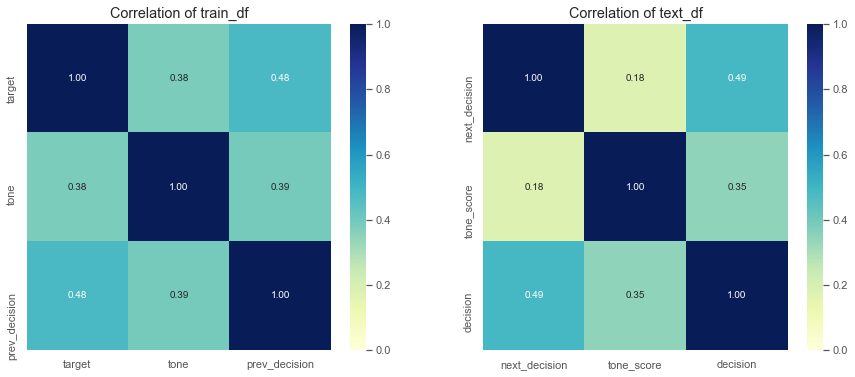

In [63]:
# Show corelations to next_decision
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))
corr_columns = ['target', 'tone', 'prev_decision']
sns.heatmap(train_df[corr_columns].astype(float).corr(), cmap="YlGnBu", annot=True, fmt=".2f", ax=ax1, vmin=0, vmax=1)
ax1.set_title("Correlation of train_df")
corr_columns = ['next_decision', 'tone_score', 'decision']
sns.heatmap(text_df[corr_columns].astype(float).corr(), cmap="YlGnBu", annot=True, fmt=".2f", ax=ax2, vmin=0, vmax=1)
ax2.set_title("Correlation of text_df")
plt.show()

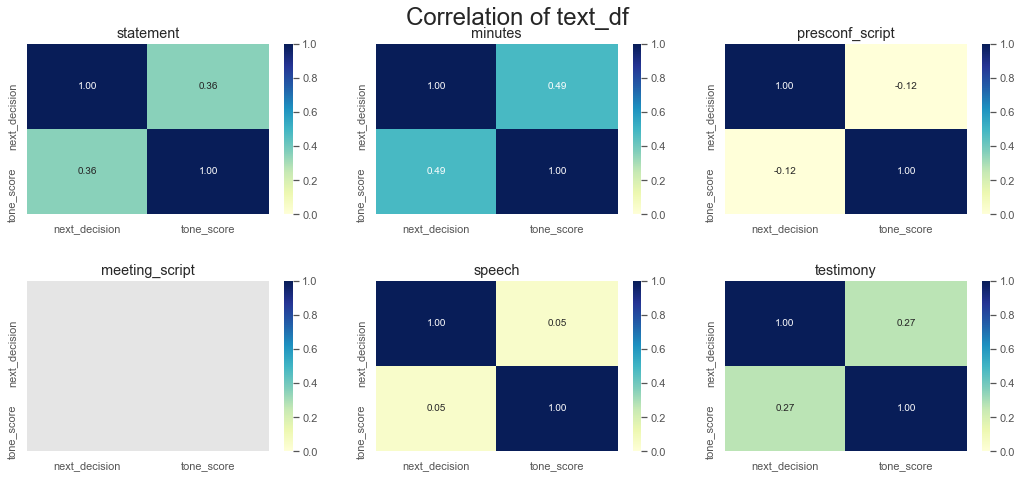

In [65]:
# Per document type
corr_columns = ['next_decision', 'tone_score', 'type']
doc_types = ['statement', 'minutes', 'presconf_script', 'meeting_script', 'speech', 'testimony']

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(15,7))

axes = [ax1, ax2, ax3, ax4, ax5, ax6]
df = text_df[corr_columns]
for i, doc_type in enumerate(doc_types):
    sns.heatmap(df.loc[df['type'] == doc_type].drop(columns=['type']).astype(float).corr(), cmap="YlGnBu", annot=True, fmt=".2f", vmin=0, vmax=1, ax=axes[i])
    axes[i].set_title(doc_type)

fig.suptitle('Correlation of text_df', fontsize=24)
fig.tight_layout(pad=3.0)
plt.show()

# Tokenize and vectorize

In [43]:
def lemmatize_word(word):
    '''
    Return the same word after lemmatizing the input word
    '''
    wnl = nltk.stem.WordNetLemmatizer()
    return wnl.lemmatize(wnl.lemmatize(word, 'n'), 'v')

def tokenize_df(df, col='text'):
    '''
    Extract words which are only aphabet and not in stop word, covert to lower case.
    '''
    tokenized = []
    wnl = nltk.stem.WordNetLemmatizer()
    for text in tqdm(df[col]):
        # Filter alphabet words only and non stop words, make it loser case
        words = [word.lower() for word in word_tokenize(text) if ((word.isalpha()==1) & (word not in stop))]
        # Lemmatize words 
        tokens = [lemmatize_word(word) for word in words]
        tokenized.append(tokens)
    return tokenized


## Tokenize text_df

In [44]:
tokenized_org = tokenize_df(text_df)
print('len(tokenized_org): ', len(tokenized_org))
print(tokenized_org[0])


len(tokenized_org):  1068
['chairman', 'alan', 'greenspan', 'announce', 'today', 'federal', 'open', 'market', 'committee', 'decide', 'increase', 'slightly', 'degree', 'pressure', 'reserve', 'position', 'the', 'action', 'expect', 'associate', 'small', 'increase', 'money', 'market', 'interest', 'rate', 'the', 'decision', 'take', 'move', 'toward', 'le', 'accommodative', 'stance', 'monetary', 'policy', 'order', 'sustain', 'enhance', 'economic', 'expansion', 'chairman', 'greenspan', 'decide', 'announce', 'action', 'immediately', 'avoid', 'misunderstand', 'committee', 'purpose', 'give', 'fact', 'first', 'firm', 'reserve', 'market', 'condition', 'committee', 'since', 'early']


In [45]:
# Concat the list to create docs
lemma_docs_org = [" ".join(words) for words in tokenized_org]
print('len(lemma_docs_org): ', len(lemma_docs_org))
print(lemma_docs_org[0])

len(lemma_docs_org):  1068
chairman alan greenspan announce today federal open market committee decide increase slightly degree pressure reserve position the action expect associate small increase money market interest rate the decision take move toward le accommodative stance monetary policy order sustain enhance economic expansion chairman greenspan decide announce action immediately avoid misunderstand committee purpose give fact first firm reserve market condition committee since early


In [46]:
# Create a list of all the words in the dataframe
all_words_org = [word for text in tokenized_org for word in text]
print('len(all_words_org): ', len(all_words_org))
print(all_words_org[0])

# Counter object of all the words
counts_org = Counter(all_words_org)
print('len(counts_org): ', len(counts_org))

# Create a Bag of Word, sorted by the count of words
bow_org = sorted(counts_org, key=counts_org.get, reverse=True)
print('bow_org[:20]', bow_org[:20])

# Indexing vocabrary, starting from 1.
vocab_org = {word: ii for ii, word in enumerate(counts_org, 1)}
id2vocab_org = {v: k for k, v in vocab_org.items()}

print("vocab_org['chairman']: ", vocab_org['chairman'])
print("vocab_org['market']: ", vocab_org['market'])

len(all_words_org):  1816700
chairman
len(counts_org):  20411
bow_org[:20] ['market', 'rate', 'the', 'inflation', 'economic', 'financial', 'price', 'policy', 'federal', 'bank', 'committee', 'growth', 'increase', 'would', 'year', 'in', 'continue', 'economy', 'reserve', 'i']
vocab_org['chairman']:  1
vocab_org['market']:  8


In [47]:
# Create token id list
token_ids_org = [[vocab_org[word] for word in text_words] for text_words in tokenized_org]
print(len(token_ids_org))

1068


In [48]:
# Add to the dataframe
text_df['tokenized'] = tokenized_org
text_df['token_ids'] = token_ids_org

In [49]:
# # Filter by frequency of words
# # This time, switch it off as the frequency is already considered while creating the vocabrary

# freq = {}
# num_words = len(all_words)
# print('len(all_words): ', len(all_words))

# for key in counts:
#     freq[key] = counts[key]/num_words

# print('len(freq): ', len(freq))
# print(freq['rate'])

# low_cutoff = 0.000001
# high_cutoff = 20

# K_most_common, K_most_common_values = zip(*counts.most_common()[:high_cutoff])

# filtered_words = [word for word in freqs if (freqs[word] > low_cutoff and word not in K_most_common)]
# print(K_most_common)
# print('len(filtered_words): ', len(filtered_words))

## Tokenize train_df

In [50]:
tokenized = tokenize_df(train_df)
print('len(tokenized): ', len(tokenized))
print(tokenized[0])

# Concat the list to create docs
lemma_docs = [" ".join(words) for words in tokenized]
print('len(lemma_docs): ', len(lemma_docs))
print(lemma_docs[0])

# Create a list of all the words in the dataframe
all_words = [word for text in tokenized for word in text]
print('len(all_words): ', len(all_words))
print(all_words[0])

# Counter object of all the words
counts = Counter(all_words)
print('len(counts): ', len(counts))

# Create a Bag of Word, sorted by the count of words
bow = sorted(counts, key=counts.get, reverse=True)
print('bow[:20]', bow[:20])

# Indexing vocabrary, starting from 1.
vocab = {word: ii for ii, word in enumerate(counts, 1)}
id2vocab = {v: k for k, v in vocab.items()}

# Create token id list
token_ids = [[vocab[word] for word in text_words] for text_words in tokenized]
print(len(token_ids))

# Add to the dataframe
train_df['tokenized'] = tokenized
train_df['token_ids'] = token_ids


len(tokenized):  245
['the', 'secretary', 'report', 'advice', 'election', 'reserve', 'bank', 'member', 'alternate', 'member', 'federal', 'open', 'market', 'committee', 'period', 'commence', 'january', 'end', 'december', 'receive', 'individual', 'execute', 'oath', 'office', 'the', 'elect', 'member', 'alternate', 'member', 'follow', 'by', 'unanimous', 'vote', 'committee', 'elect', 'follow', 'officer', 'federal', 'open', 'market', 'committee', 'serve', 'election', 'successor', 'first', 'meet', 'committee', 'december', 'understand', 'event', 'discontinuance', 'official', 'connection', 'board', 'governor', 'federal', 'reserve', 'bank', 'would', 'cease', 'official', 'connection', 'federal', 'open', 'market', 'committee', 'by', 'unanimous', 'vote', 'william', 'mcdonough', 'margaret', 'greene', 'joan', 'lovett', 'select', 'serve', 'pleasure', 'committee', 'capacity', 'manager', 'system', 'open', 'market', 'account', 'deputy', 'manager', 'foreign', 'operation', 'system', 'open', 'market', 'acc

245


/Users/yuki/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/yuki/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


## Lemmatize sentiment

In [51]:
# pd.get_dummies(sentiment_df, prefix=None, dtype=bool)
# sentiment_df.columns = [column.lower() for column in sentiment_df.columns]

# Lemmertize sentiment words as well
lemma_sentiment_df = sentiment_df.copy(deep=True)
lemma_sentiment_df['word'] = [lemmatize_word(word) for word in lemma_sentiment_df['word']]
# Drop duplicates
lemma_sentiment_df = sentiment_df.drop_duplicates('word')
# Sentiment list
lemma_sentiments = list(lemma_sentiment_df['sentiment'].unique())

In [52]:
lemma_sentiment_df.groupby(by=['sentiment']).count()

,word
sentiment,
Constraining,145
Litigious,750
Negative,2355
Positive,354
StrongModal,15
Uncertainty,257


## Tfidf 

In [53]:
from sklearn.feature_extraction.text import TfidfVectorizer

def get_tfidf(sentiment_words, docs):
    """
    Generate TFIDF values from documents for a certain sentiment

    Parameters
    ----------
    sentiment_words: Pandas Series
        Words that signify a certain sentiment
    docs : list of str
        List of documents used to generate bag of words

    Returns
    -------
    tfidf : 2-d Numpy Ndarray of float
        TFIDF sentiment for each document
        The first dimension is the document.
        The second dimension is the word.
    """
    vectorizer = TfidfVectorizer(analyzer='word', vocabulary=sentiment_words)
    tfidf = vectorizer.fit_transform(docs)
    features = vectorizer.get_feature_names()
    
    return tfidf.toarray()

### Text dataframe

In [54]:
# Using the get_tfidf function, let's generate the TFIDF values for all the documents.
sentiment_tfidf_org = {
        sentiment: get_tfidf(lemma_sentiment_df.loc[lemma_sentiment_df['sentiment'] == sentiment]['word'], lemma_docs_org)
        for sentiment in lemma_sentiments}

print(len(sentiment_tfidf_org['Negative']))
print(len(sentiment_tfidf_org['Negative'][0]))

1068
2355


In [55]:
text_df.shape

(1068, 19)

In [56]:
for sentiment in lemma_sentiments:
    text_df['tfidf_' + sentiment] = list(sentiment_tfidf_org[sentiment])
    
text_df

,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,...,pos_words,neg_words,tokenized,token_ids,tfidf_Negative,tfidf_Positive,tfidf_Uncertainty,tfidf_Litigious,tfidf_StrongModal,tfidf_Constraining
0,statement,1994-02-04,FOMC Statement,Alan Greenspan,99,1,3.25,1994-02-28,0,3.25,...,[enhance],[misunderstanding],"[chairman, alan, greenspan, announce, today, f...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,statement,1994-03-22,FOMC Statement,Alan Greenspan,40,1,3.5,1994-04-18,1,3.75,...,[],[],"[chairman, alan, greenspan, announce, today, f...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,statement,1994-04-18,FOMC Statement,Alan Greenspan,37,1,3.75,1994-05-17,1,4.25,...,[],[],"[chairman, alan, greenspan, announce, today, f...","[1, 2, 3, 4, 5, 6, 15, 11, 12, 13, 14, 15, 16,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,statement,1994-05-17,FOMC Statement,Alan Greenspan,57,1,4.25,1994-07-06,0,4.25,...,[],[],"[in, take, discount, action, board, approve, r...","[51, 26, 52, 18, 53, 54, 55, 56, 53, 57, 58, 6...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,statement,1994-08-16,FOMC Statement,Alan Greenspan,51,1,4.75,1994-09-27,0,4.75,...,[],[],"[in, take, discount, rate, action, board, appr...","[51, 26, 52, 24, 18, 53, 54, 55, 56, 53, 57, 6...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
5,statement,1994-11-15,FOMC Statement,Alan Greenspan,121,1,5.5,1994-12-20,0,5.50,...,[strength],"[against, persistent]","[in, relate, move, federal, open, market, comm...","[51, 79, 27, 6, 7, 8, 9, 10, 11, 52, 24, 80, 8...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
6,statement,1995-02-01,FOMC Statement,Alan Greenspan,54,1,6,1995-03-10,0,6.00,...,[],[],"[in, take, discount, action, board, approve, r...","[51, 26, 52, 18, 53, 54, 55, 56, 53, 57, 6, 15...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
7,statement,1995-07-06,FOMC Statement,Alan Greenspan,67,-1,5.75,1995-08-22,0,5.75,...,[],"[tightening, decline]","[chairman, alan, greenspan, announce, today, f...","[1, 2

### Train dataframe

In [57]:
# Using the get_tfidf function, let's generate the TFIDF values for all the documents.
sentiment_tfidf = {
        sentiment: get_tfidf(lemma_sentiment_df.loc[lemma_sentiment_df['sentiment'] == sentiment]['word'], lemma_docs)
        for sentiment in lemma_sentiments}

print(len(sentiment_tfidf['Negative']))
print(len(sentiment_tfidf['Negative'][0]))

for sentiment in lemma_sentiments:
    train_df['tfidf_' + sentiment] = list(sentiment_tfidf[sentiment])
    
train_df

245
2355


/Users/yuki/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


,target,prev_decision,GDP_diff_prev,PMI_value,Employ_diff_prev,Rsales_diff_year,Unemp_diff_prev,Inertia_diff,Hsales_diff_year,Balanced_diff,...,text,tone,tokenized,token_ids,tfidf_Negative,tfidf_Positive,tfidf_Uncertainty,tfidf_Litigious,tfidf_StrongModal,tfidf_Constraining
date,,,,,,,,,,,,,,,,,,,,,
1993-02-18,0,0,1.043165,55.8,261.0,1.807631,0.000000,-0.015902,14.901418,0.035879,...,The Secretary reported that advices of the el...,-0.146711,"[the, secretary, report, advice, election, res...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 10, 11, 12, 13,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.034224750271236525, 0.0, 0.0, 0.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.06271366751762956, 0.18..."
1993-05-18,0,0,0.167400,50.2,126.0,3.092456,0.066667,-0.000720,13.455236,0.111134,...,"At the start of the meeting, the subcommittee...",-0.163716,"[at, start, meet, subcommittee, establish, rev...","[95, 485, 33, 348, 270, 334, 154, 357, 1127, 1...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.8597560819308422, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.07481243047159189,..."
1993-07-07,0,0,0.167400,49.6,226.5,4.263357,0.000000,0.050013,13.446869,-0.016140,...,The Committee then turned to a discussion of ...,-0.267331,"[the, committee, turn, discussion, economic, o...","[1, 13, 364, 365, 366, 367, 372, 274, 154, 373...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.086...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.10530925287224485,..."
1993-08-17,0,0,0.582420,50.2,243.5,4.611673,0.066667,0.001967,11.927296,0.028625,...,The Committee then turned to a discussion of ...,-0.110953,"[the, committee, turn, discussion, economic, o...","[1, 13, 364, 365, 366, 367, 368, 369, 370, 371...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.150...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.655408558906601, 0.0, 0.0, 0.0, 0.0, 0...","[0.0, 0.0, 0.0, 0.0, 0.07537767788891227, 0.0,..."
1993-09-21,0,0,0.582420,50.7,228.5,4.894733,0.100000,-0.006682,10.302509,-0.010715,...,Secretary's Note: Advice had been received of...,-0.170616,"[secretary, note, advice, receive, election, w...","[2, 783, 4, 19, 5, 43, 44, 39, 1640, 10, 6, 7,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.154...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.5801130206166596, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.07553466760642374,..."
1993-10-05,0,0,0.582420,50.8,196.5,4.567647,0.100000,0.001512,8.487682,-0.001201,...,"By unanimous vote, Joan E. Lovett and Peter R...",-0.168253,"[by, unanimous, vote, joan, lovett, peter, fis...","[26, 27, 28, 47, 48, 1730, 1731, 49, 30, 50, 1...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.09884381216977356, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.252...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1993-12-21,0,0,0.477315,53.8,268.0,4.732363,0.066667,0.018879,9.597330,-0.037480,...,The Committee then turned to a discussion of ...,-0.078038,"[the, committee, turn, discussion, economic, f...","[1, 13, 364, 365, 366, 277, 367, 1611, 274, 15...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0

## Cosine Similarity
Using the TFIDF values, we'll calculate the cosine similarity and plot it over time. Implement `get_cosine_similarity` to return the cosine similarities between each tick in time. Since the input, `tfidf_matrix`, is a TFIDF vector for each time period in order, you just need to computer the cosine similarities for each neighboring vector.

In [58]:
from sklearn.metrics.pairwise import cosine_similarity

def get_cosine_similarity(tfidf_matrix):
    """
    Get cosine similarities for each neighboring TFIDF vector/document

    Parameters
    ----------
    tfidf : 2-d Numpy Ndarray of float
        TFIDF sentiment for each document
        The first dimension is the document.
        The second dimension is the word.

    Returns
    -------
    cosine_similarities : list of float
        Cosine similarities for neighboring documents
    """
    #print(tfidf_matrix)
    return [cosine_similarity(u.reshape(1,-1), v.reshape(1,-1))[0][0].tolist() for u, v in zip(tfidf_matrix, tfidf_matrix[1:])]

In [86]:
cosine_similarities = {
    sentiment_name: get_cosine_similarity(sentiment_values) 
    for sentiment_name, sentiment_values in sentiment_tfidf.items()}

print(len(cosine_similarities['Negative']))

244


In [87]:
for sentiment in lemma_sentiments:
    # Add 0 to the first element as there is no comparison available to a previous value
    cosine_similarities[sentiment].insert(0, 0)
    train_df['cos_sim_' + sentiment] = cosine_similarities[sentiment]
    
train_df

/Users/yuki/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,target,prev_decision,GDP_diff_prev,PMI_value,Employ_diff_prev,Rsales_diff_year,Unemp_diff_prev,Inertia_diff,Hsales_diff_year,Balanced_diff,...,tfidf_Uncertainty,tfidf_Litigious,tfidf_StrongModal,tfidf_Constraining,cos_sim_Negative,cos_sim_Positive,cos_sim_Uncertainty,cos_sim_Litigious,cos_sim_StrongModal,cos_sim_Constraining
date,,,,,,,,,,,,,,,,,,,,,
1993-02-18,0,0,1.043165,55.8,261.0,1.807631,0.000000,-0.015902,14.901418,0.035879,...,"[0.0, 0.0, 0.034224750271236525, 0.0, 0.0, 0.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.06271366751762956, 0.18...",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1993-05-18,0,0,0.167400,50.2,126.0,3.092456,0.066667,-0.000720,13.455236,0.111134,...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.8597560819308422, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.07481243047159189,...",0.639645,0.862652,0.712663,0.116021,0.000000,0.913327
1993-07-07,0,0,0.167400,49.6,226.5,4.263357,0.000000,0.050013,13.446869,-0.016140,...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.086...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.10530925287224485,...",0.646613,0.899890,0.877962,0.712396,0.000000,0.957226
1993-08-17,0,0,0.582420,50.2,243.5,4.611673,0.066667,0.001967,11.927296,0.028625,...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.150...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.655408558906601, 0.0, 0.0, 0.0, 0.0, 0...","[0.0, 0.0, 0.0, 0.0, 0.07537767788891227, 0.0,...",0.617205,0.802198,0.691030,0.872348,0.655409,0.949805
1993-09-21,0,0,0.582420,50.7,228.5,4.894733,0.100000,-0.006682,10.302509,-0.010715,...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.154...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.5801130206166596, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.07553466760642374,...",0.677900,0.803189,0.802878,0.805610,0.327905,0.924528
1993-10-05,0,0,0.582420,50.8,196.5,4.567647,0.100000,0.001512,8.487682,-0.001201,...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.252...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.649657,0.812911,0.646603,0.884278,0.000000,0.917345
1993-12-21,0,0,0.477315,53.8,268.0,4.732363,0.066667,0.018879,9.597330,-0.037480,...,"[0.0, 0.0, 0.05343488799931058, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.4055561065600731, 0.0, 0.0, 0.62447156...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.18206759265477737,...",0.525477,0.827802,0.804055,0.620993,0.405556,0.891773
1994-02-04,1,0,1.360113,56.0,305.5,3.968305,0.066667,0.027275,11.608081,-0.077404,...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.121...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.6017853916680911, 0.0, 0.0, 0.46331181...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.426173,0.854964,0.898860,0.694928,0.899609,0.833488
1994-02-28,0,1,1.360113,56.0,305.5,3.968305,0.066667,0.047744,11.608081,-0.028708,...,"[0.0, 0.0, 0.03755917781111165, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.737893739042361, 0.0, 0.0, 0.0, 0.0, 0...","[0.0, 0.0, 0.0, 0.0, 0.06720293632205765, 0.13...",0.482272,0.827544,0.865891,0.113322,0.815545,0.923690


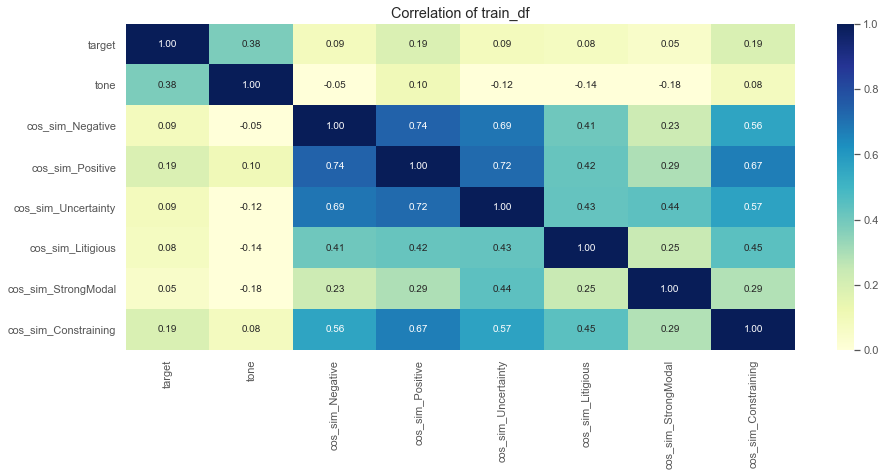

In [88]:
# Show corelations to target
fig, ax = plt.subplots(figsize=(15,6))
corr_columns = ['target', 'tone', 'cos_sim_Negative', 'cos_sim_Positive', 'cos_sim_Uncertainty', 'cos_sim_Litigious', 'cos_sim_StrongModal', 'cos_sim_Constraining']
sns.heatmap(train_df[corr_columns].astype(float).corr(), cmap="YlGnBu", annot=True, fmt=".2f", ax=ax, vmin=0, vmax=1)
ax.set_title("Correlation of train_df")
plt.show()

## Training Data

In [96]:
def convert_class(x):
    if x == 1:
        return 3
    elif x == 0:
        return 2
    elif x == -1:
        return 1

In [97]:
train_df.columns

Index(['target', 'prev_decision', 'GDP_diff_prev', 'PMI_value',
       'Employ_diff_prev', 'Rsales_diff_year', 'Unemp_diff_prev',
       'Inertia_diff', 'Hsales_diff_year', 'Balanced_diff', 'statement',
       'minutes', 'presconf_script', 'speech', 'testimony', 'text', 'tone',
       'tokenized', 'token_ids', 'tfidf_Negative', 'tfidf_Positive',
       'tfidf_Uncertainty', 'tfidf_Litigious', 'tfidf_StrongModal',
       'tfidf_Constraining', 'cos_sim_Negative', 'cos_sim_Positive',
       'cos_sim_Uncertainty', 'cos_sim_Litigious', 'cos_sim_StrongModal',
       'cos_sim_Constraining'],
      dtype='object')

In [105]:
Y_data = train_df['target'].map(convert_class)
X_data = train_df.drop(columns=['target', 'statement', 'minutes', 'presconf_script', 'speech', 'testimony', 
                                'text', 'tokenized', 'token_ids', 'tfidf_Negative', 'tfidf_Positive',
       'tfidf_Uncertainty', 'tfidf_Litigious', 'tfidf_StrongModal',
       'tfidf_Constraining'])

In [117]:
# Because the prediction should be on the latest and should not look back, use shuffle=False
X_train, X_test, Y_train, Y_test = \
model_selection.train_test_split(X_data.values, Y_data.values, test_size=0.2, shuffle=True)

# Modeling and Training

In [118]:
# Use Stratified KFold Cross Validation
# Training data is not so many, keep n_split <= 5
kfold = StratifiedKFold(n_splits=3)
kfold

StratifiedKFold(n_splits=3, random_state=None, shuffle=False)

In [101]:
# Define metrics
# Here, use F1 Macro to evaluate the model.
def metric(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='macro')
    return acc, f1

scoring = {'Accuracy': 'accuracy', 'F1': 'f1_macro'}
refit = 'F1'

In [102]:
def train_grid_search(estimator, param_grid, scoring, refit, cv=5, verbose=1, plot=True):
    model = GridSearchCV(estimator, param_grid=param_grid, cv=cv, scoring=scoring, verbose=verbose, 
                         refit=refit, n_jobs=-1, return_train_score=True)
    model.fit(X_train, Y_train)
    
    results = model.cv_results_
    best_estimator = model.best_estimator_
    train_scores = results['mean_train_' + refit]
    test_scores = results['mean_test_' + refit]
    train_time = results['mean_fit_time']
    
    print("Best Score: ", model.best_score_)
    print("Best Param: ", model.best_params_)
    
    pred_train = best_estimator.predict(X_train)
    pred_test = best_estimator.predict(X_test)

    acc, f1 = metric(Y_train, pred_train)
    logger.info('Training - acc: %.8f, f1: %.8f' % (acc, f1))
    acc, f1 = metric(Y_test, pred_test)
    logger.info('Test - acc: %.8f, f1: %.8f' % (acc, f1))
        
    if plot:
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
        fig.suptitle("GridSearchCV Result", fontsize=20)
        
        ### First plot ###
        ax1.plot(train_scores, test_scores, 'bo')
        ax1.set_title("Train Score v.s. Test Score", fontsize=16)
        ax1.set_xlabel("Train Score")
        ax1.set_ylabel("Test Score")
        ax1.set_xlim(0, 1)
        ax1.set_ylim(0, 1)
        ax1.grid(True)
        
        ### Second plot ###
        x_param = list(param_grid.keys())[0]
        x_param_min = np.min(list(param_grid.values())[0])
        x_param_max = np.max(list(param_grid.values())[0])

        ax2.set_title("Score over the first param", fontsize=16)
        ax2.set_xlabel(x_param)
        ax2.set_ylabel("Score")
        ax2.set_xlim(x_param_min, x_param_max)
        ax2.set_ylim(0, 1)

        # Get the regular numpy array from the MaskedArray
        X_axis = np.array(results['param_' + x_param].data, dtype=float)

        for scorer, color in zip(sorted(scoring), ['r', 'g']):
            for sample, style in (('train', '--'), ('test', '-')):
                sample_score_mean = results['mean_%s_%s' % (sample, scorer)]
                sample_score_std = results['std_%s_%s' % (sample, scorer)]
                ax2.fill_between(X_axis, sample_score_mean - sample_score_std,
                                sample_score_mean + sample_score_std,
                                alpha=0.1 if sample == 'test' else 0, color=color)
                ax2.plot(X_axis, sample_score_mean, style, color=color,
                        alpha=1 if sample == 'test' else 0.7,
                        label="%s (%s)" % (scorer, sample.capitalize()))

            best_index = np.nonzero(results['rank_test_%s' % scorer] == 1)[0][0]
            best_score = results['mean_test_%s' % scorer][best_index]

            # Plot a dotted vertical line at the best score for that scorer marked by x
            ax2.plot([X_axis[best_index], ] * 2, [0, best_score],
                    linestyle='-.', color=color, marker='x', markeredgewidth=3, ms=8)

            # Annotate the best score for that scorer
            ax2.annotate("%0.2f" % best_score,
                        (X_axis[best_index], best_score + 0.005))

        ax2.legend(loc="best")
        ax2.grid(False)
        
        ### Third plot (Learning Curve) ###
        # Calculate learning curve (Accuracy)
        lc_acc_train_sizes, lc_acc_train_scores, lc_acc_test_scores = learning_curve(
            best_estimator, X_train, Y_train, cv=kfold, n_jobs=-1, scoring=scoring['Accuracy'], 
            train_sizes=np.linspace(.1, 1.0, 5))
        lc_acc_train_mean = np.mean(lc_acc_train_scores, axis=1)
        lc_acc_train_std = np.std(lc_acc_train_scores, axis=1)
        lc_acc_test_mean = np.mean(lc_acc_test_scores, axis=1)
        lc_acc_test_std = np.std(lc_acc_test_scores, axis=1)
        
        # Calculate learning curve (F1 Score)
        lc_f1_train_sizes, lc_f1_train_scores, lc_f1_test_scores = learning_curve(
            best_estimator, X_train, Y_train, cv=kfold, n_jobs=-1, scoring=scoring['F1'], 
            train_sizes=np.linspace(.1, 1.0, 5))
        lc_f1_train_mean = np.mean(lc_f1_train_scores, axis=1)
        lc_f1_train_std = np.std(lc_f1_train_scores, axis=1)
        lc_f1_test_mean = np.mean(lc_f1_test_scores, axis=1)
        lc_f1_test_std = np.std(lc_f1_test_scores, axis=1)
        
        ax3.set_title("Learning Curve", fontsize=16)
        ax3.set_xlabel("Training examples")
        ax3.set_ylabel("Score")

        # Plot learning curve (Accuracy)
        ax3.fill_between(lc_acc_train_sizes, 
                         lc_acc_train_mean - lc_acc_train_std,
                         lc_acc_train_mean + lc_acc_train_std, alpha=0.1, color="r")
        ax3.fill_between(lc_acc_train_sizes, 
                         lc_acc_test_mean - lc_acc_test_std,
                         lc_acc_test_mean + lc_acc_test_std, alpha=0.1, color="r")
        ax3.plot(lc_acc_train_sizes, lc_acc_train_mean, 'o--', color="r",
                 label="Accuracy (Train)")
        ax3.plot(lc_acc_train_sizes, lc_acc_test_mean, 'o-', color="r",
                 label="Accuracy (Test)")
        
        # Plot learning curve (F1 Score)
        ax3.fill_between(lc_f1_train_sizes, 
                         lc_f1_train_mean - lc_f1_train_std,
                         lc_f1_train_mean + lc_f1_train_std, alpha=0.1, color="g")
        ax3.fill_between(lc_f1_train_sizes, 
                         lc_f1_test_mean - lc_f1_test_std,
                         lc_f1_test_mean + lc_f1_test_std, alpha=0.1, color="g")
        ax3.plot(lc_f1_train_sizes, lc_f1_train_mean, 'o--', color="g",
                 label="F1 (Train)")
        ax3.plot(lc_f1_train_sizes, lc_f1_test_mean, 'o-', color="g",
                 label="F1 (Test)")

        ax3.legend(loc="best")
        ax3.grid(True)
        
        plt.tight_layout(pad=3.0)
        plt.show()
        
        ### Confusion Matrix ###
        class_names = ['Lower', 'Hold', 'Raise']
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
        fig.suptitle("Confusion Matrix", fontsize=20)
        
        plot_confusion_matrix(best_estimator, X_train, Y_train, display_labels=class_names, 
                              cmap=plt.cm.Blues, normalize=None, ax=ax1)
        ax1.set_title("Train Data: Actual Count")
        ax1.grid(False)
        
        plot_confusion_matrix(best_estimator, X_train, Y_train, display_labels=class_names, 
                              cmap=plt.cm.Blues, normalize='all', ax=ax2)
        ax2.set_title=("Train Data: Normalized")
        ax2.grid(False)
        
        plot_confusion_matrix(best_estimator, X_test, Y_test, display_labels=class_names, 
                              cmap=plt.cm.Blues, normalize=None, ax=ax3)
        ax3.set_title=("Test Data: Actual Count")
        ax3.grid(False)
        
        plot_confusion_matrix(best_estimator, X_test, Y_test, display_labels=class_names, 
                              cmap=plt.cm.Blues, normalize='all', ax=ax4)
        ax4.set_title("Test Data: Normalized")
        ax4.grid(False)
        
        plt.tight_layout(pad=3.0)
        plt.show()
    
    return model


Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    1.1s finished
[2020-06-20 09:49:22,956][INFO] ## Training - acc: 1.00000000, f1: 1.00000000
[2020-06-20 09:49:22,958][INFO] ## Test - acc: 0.59183673, f1: 0.51786994


Best Score:  0.5988544196244298
Best Param:  {'bootstrap': False, 'criterion': 'gini', 'max_depth': None, 'max_features': 7, 'min_samples_leaf': 3, 'min_samples_split': 3, 'n_estimators': 20}


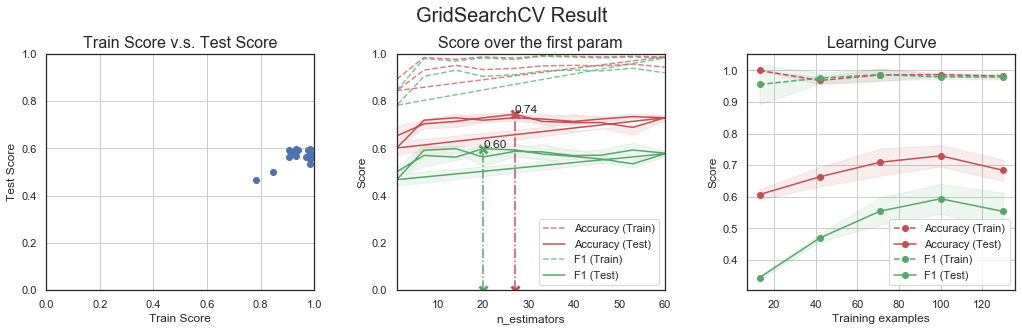

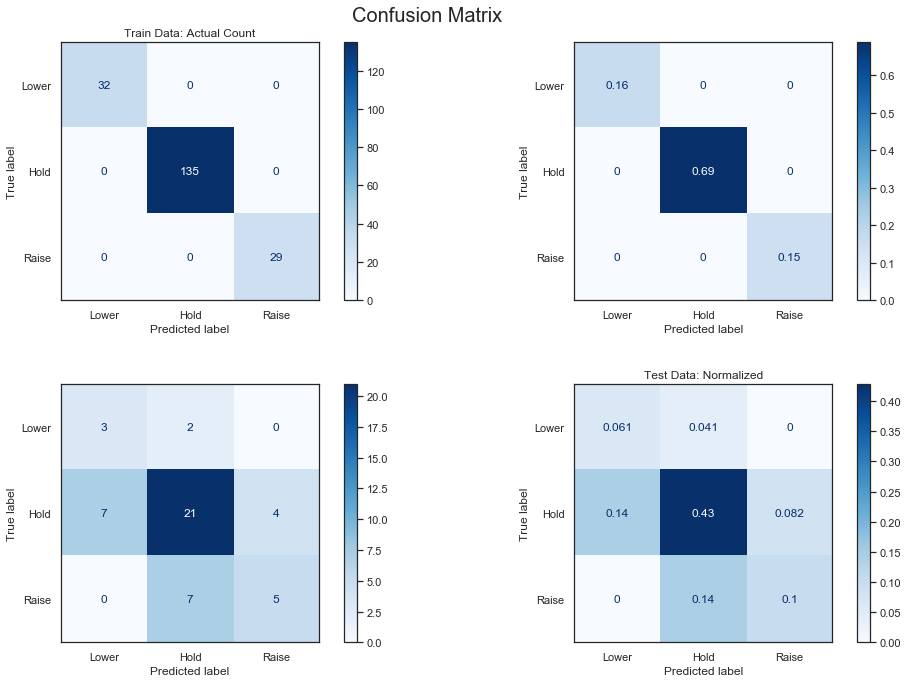

In [119]:
# Random Forest
rf_clf = RandomForestClassifier()

# Perform Grid Search
param_grid = {'n_estimators': np.linspace(1, 60, 10, dtype=int),
              'min_samples_split': [3, 10],
              'min_samples_leaf': [3],
              'max_features': [7],
              'max_depth': [None],
              'criterion': ['gini'],
              'bootstrap': [False]}

rf_model = train_grid_search(rf_clf, param_grid, scoring, refit, cv=kfold, verbose=1, plot=True)
rf_best = rf_model.best_estimator_

# Glove Word Embedding
Use GloVe word embedding instead of Tfidf

### Download GloVe files

In [ ]:
# Use 6B 300d
glove_file = 'glove.6B.300d.pickle'

if IN_COLAB:
    glove_dir = 'drive/My Drive/Colab Data/'
else:
    glove_dir = '../data/GloVe/'

glove_path = glove_dir + glove_file
    
# Download Glove file if not exist
if not os.path.exists(glove_path):
    if not os.path.exists(glove_path):
        os.mkdir(glove_path)
    !wget -o ${glove_dir} http://nlp.stanford.edu/data/glove.6B.zip
    !unzip ${glove_dir}glove*.zip

    embedding_dict = {}

    with open(glove_dir + "glove.6B.300d.txt", 'r') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vectors = np.asarray(values[1:], 'float32')
            embedding_dict[word] = vectors
    f.close()

    pickle.dump(embedding_dict, open(glove_path, 'wb'))

In [ ]:
glove_dict = pickle.load(open(glove_path, 'rb'))
print(len(glove_dict))
glove_dict['the']

In [ ]:
weight_matrix = np.zeros((len(vocab), 300))
words_found = 0

for i, word in enumerate(vocab):
    try:
        weight_matrix[i] = glove_dict[word]
        words_found += 1
    except KeyError:
        weight_matrix[i] = np.random.normal(scale=0.6, size=(300,))

print('{} words found out of {} words in vocab.'.format(words_found, len(vocab)))
print(weight_matrix.shape)

In [ ]:
type(weight_matrix)

# Save Data

In [ ]:
def save_data(df, file_name, dir_name='../data/train_data/'):
    if not os.path.exists(dir_name):
        os.mkdir(dir_name)
        
    # Save results to a picke file
    file = open(dir_name + file_name + '.pickle', 'wb')
    pickle.dump(df, file)
    file.close()

    # Save results to a csv file
    df.to_csv(dir_name + file_name + '.csv', index=True)

In [ ]:
# Save text data
save_data(train_df, 'train_df')
save_data(text_df, 'text_df')